In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import seaborn as sns
# sns.set(color_codes = True)
%matplotlib inline

In [4]:
jtplot.style(theme='monokai')

# Data Importing and Cleaning

### Chart Data

In [31]:
chart_df = pd.read_csv('../data/all_charts.csv')
chart_df = chart_df[['chartDate', 
                     'title', 
                     'artist', 
                     'peakPos', 
                     'lastPos',
                     'weeks',
                     'rank',
                     'change',
                     'spotifyID']]
chart_df['chartDate'] = pd.to_datetime(chart_df[('chartDate')])
chart_df['year'] = chart_df['chartDate'].dt.year
chart_df['month'] = chart_df['chartDate'].dt.month
chart_df['rank_weight'] = 101 - chart_df['rank'] 

/Users/AndrewKraemer/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (18,19,20,21,22,23,24,25,26,27,28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Spotify Data

In [11]:
spotify_df = pd.read_csv('../data/spotify_data.csv')
spotify_df = spotify_df.drop_duplicates() # remove one spotify dup
spotify_df['maj_minor'] = spotify_df['key_mode'].str.split(' ', 1).str[1]

### Lyrics Data

#### Import and clean data

In [21]:
lyrics_df = pd.read_csv('../data/lyrics.csv')
lyrics_df = lyrics_df[lyrics_df['Source'].notnull()] # remove songs without lyrics

In [28]:
# Create TextBlob object. Extract polarity score
from textblob import TextBlob
lyrics_df['tb_obj'] = lyrics_df['Lyrics'].apply(lambda lyric: TextBlob(lyric)) # takes a bit to run
lyrics_df['polarity'] = lyrics_df['tb_obj'].apply(lambda tb_obj: tb_obj.sentiment.polarity)
lyrics_df['polarity'] = lyrics_df['polarity'].apply(lambda x: (x + 1) / 2) # converts (-1,1) score to (0,1)

#### Word Analysis

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words='english', max_features=5000)
vectorized = cv.fit_transform(lyrics_df['Lyrics'])
words = cv.get_feature_names()

word_counts = pd.DataFrame.from_dict({word: vectorized.getcol(idx).sum() for word, idx in cv.vocabulary_.items()}, orient='index').reset_index()
word_counts.columns = ['word', 'count'] # rename columns

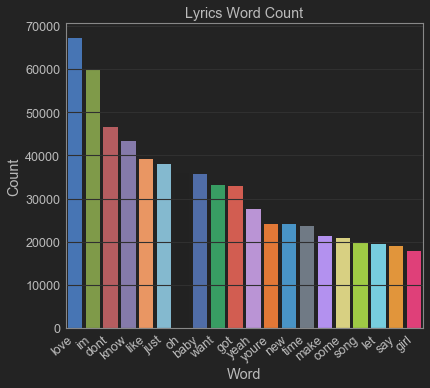

In [27]:
top_words = word_counts.sort_values('count', ascending = False).head(20)
sns.barplot(x = 'word', 
            y = 'count', data = top_words )
plt.xlabel('Word')
plt.ylabel('Count')
plt.xticks(rotation=40, ha = 'right')
plt.title('Lyrics Word Count')
plt.show()

### Join Data

In [46]:
df = pd.merge(chart_df, spotify_df, left_on='spotifyID', right_on = 'track_uri', how='inner')
df = pd.merge(df, lyrics_df, left_on='spotifyID', right_on = 'spotifyID', how='inner')

In [96]:
import operator
def quick_filter(df, bort, peak_pos_thresh = 5):        
    spot_flds = ['chartDate', 'title', 'artist', 'peakPos', 'valence', 'energy', 'polarity', 'happy_index']
    return df[bort & (df['peakPos'] < 5)][spot_flds].drop_duplicates(subset = ['title', 'artist'])

# quick_filter(df, (df['valence'] < .2) & (df['energy'] < .2))
# Can You Feel The Love Tonight by Elton John (142471)

# quick_filter(df, (df['valence'] > .8) & (df['energy'] < .4))
# Bang Bang (My Baby Shot Me Down) nancy sinatra

# quick_filter(df, (df['valence'] > .8) & (df['energy'] > .8))
# surfin usa beach boys, splish splash, if I had a hammer, timber pitbull + kesha, hey yah outcast

# quick_filter(df, (df['valence'] < .3) & (df['energy'] > .8))
# Like A Prayer	Madonna, My Sacrifice Creed

,chartDate,title,artist,peakPos,valence,energy,polarity,happy_index
10075,1960-11-19,Wonderland By Night,Bert Kaempfert And His Orchestra,1,0.1550,0.1150,0.500000,0.346501
37715,1968-01-20,(Theme From) Valley Of The Dolls,Dionne Warwick,2,0.1130,0.1510,0.575000,0.381800
42598,1969-05-10,Love Theme From Romeo & Juliet,Henry Mancini And His Orchestra,1,0.1730,0.1180,0.500000,0.354706
52395,1972-03-04,The First Time Ever I Saw Your Face,Roberta Flack,1,0.1390,0.0264,0.639418,0.390451
62258,1974-08-17,I Honestly Love You,Olivia Newton-John,1,0.0878,0.1350,0.517343,0.339192
72207,1977-02-26,When I Need You,Leo Sayer,1,0.1710,0.1970,0.582635,0.421750
78110,1978-07-15,You Needed Me,Anne Murray,1,0.1890,0.1470,0.549992,0.394714
85241,1980-03-22,The Rose,Bette Midler,3,0.0767,0.0971,0.569288,0.346513
100202,1984-02-25,Against All Odds (Take A Look At Me Now),Phil Collins,1,0.1650,0.1870,0.562727,0.406057
142471,1994-05-21,"Can You Feel The Love Tonight (From ""The Lion ...",Elton John,4,0.1670,0.1790,0.655556,0.450181


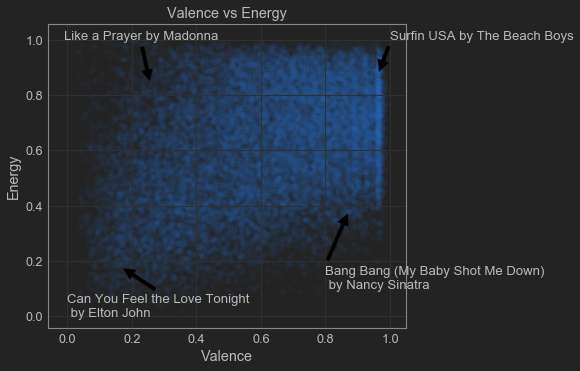

In [98]:
# Show off the differences 
plt.scatter(spotify_df['valence'], spotify_df['energy'], alpha = .05)
plt.title('Valence vs Energy')
plt.xlabel('Valence')
plt.ylabel('Energy')
plt.annotate('Like a Prayer by Madonna', xy=(0.2570, 0.842), xytext = (-.01,1), 
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Surfin USA by The Beach Boys', xy=(0.964, 0.878), xytext = (1,1), 
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Bang Bang (My Baby Shot Me Down) \n by Nancy Sinatra', xy=(0.873, 0.382), xytext = (.8,.1), 
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('Can You Feel the Love Tonight \n by Elton John', xy=(0.1670, 0.1790), xytext = (0,0), 
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

In [123]:
# quick_filter(df, (df['polarity'] < .4))
# Bridge Over Troubled Water \n by Simon & Garfunkel
# quick_filter(df, (df['polarity'] > .65))
# You're Beautiful by James Blunt

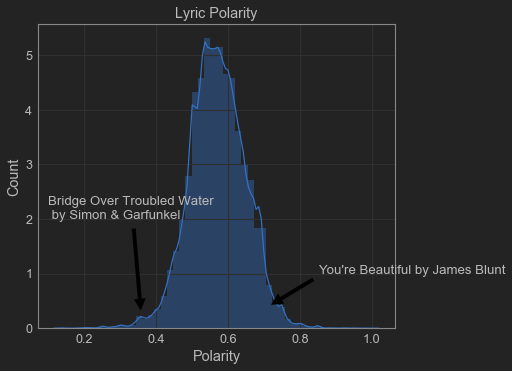

In [126]:
sns.distplot(df['polarity']) #kde = False
plt.title('Lyric Polarity')
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.annotate('Bridge Over Troubled Water \n by Simon & Garfunkel', 
             xy=(0.358322, 0.236), 
             xytext = (.1, 2), 
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate("You're Beautiful by James Blunt", 
             xy=(0.712690,.4), 
             xytext = (.85, 1), 
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

Create Happy_Index by combining *valence* and *energy* from Spotify with the *polarity* of the Lyrics. 

In [48]:
from sklearn.metrics.pairwise import euclidean_distances
coord = df['coord'] =[[df['valence'].iloc[i], df['energy'].iloc[i]] for i in range(df.shape[0])]
df['happy_dist'] = euclidean_distances(coord, [[0, 0]])
df['happy_index'] = (df['happy_dist'] + df['polarity'])/2

#### Missing Data

In [ ]:
chart_len = chart_df.shape[0]
spot_len = df.shape[0]
print('chart_songs: ' + str(chart_len), 
     '\nspotify_songs: ' + str(spot_len),
     '\npercent_overlap: ' + str(round((spot_len / chart_len)*100, 2)) + '%')